# Creación de un modelo desde cero con aumento de imágenes

## Librerías necesarias

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

## Variables globales del sistema

In [18]:
original_dir = pathlib.Path("DatasetOriginal/Image Data Base")
new_base_dir = pathlib.Path("ExpandedDataset/")
content = os.listdir(original_dir)
BATCH_SIZE = 64
size_x = 256
size_y = 256

## Función para contar imágenes por categorías

In [16]:
def categories_counter():
    counter_more200 = 0
    counter_less200 = 0
    categories = {}
    for category in content:
        counter = 0
        for path in pathlib.Path(original_dir / category).iterdir():   
            counter += 1
        if counter < 200:
            counter_less200 += 1
            categories.update({str(category):counter})
            
        else:
            counter_more200 += 1
    print("Hay "+ str(counter_more200) + " categorias con más de 200 ejemplos")
    print("Hay "+ str(counter_less200) + " categorias con menos de 200 ejemplos")
    return categories
        
categories = categories_counter()

Hay 34 categorias con más de 200 ejemplos
Hay 24 categorias con menos de 200 ejemplos


In [17]:
print(categories)

{'algal leaf in tea': 113, 'anthracnose in tea': 100, 'Bacterial leaf blight in rice leaf': 40, 'bird eye spot in tea': 100, 'brown blight in tea': 113, 'Brown spot in rice leaf': 40, 'cabbage looper': 78, 'Cercospora leaf spot': 63, 'corn crop': 104, 'Garlic': 49, 'ginger': 45, 'healthy tea leaf': 74, 'Leaf smut in rice leaf': 40, 'lemon canker': 61, 'Nitrogen deficiency in plant': 11, 'onion': 20, 'potassium deficiency in plant': 18, 'potato crop': 40, 'Potato healthy': 122, 'potato hollow heart': 60, 'red leaf spot in tea': 143, 'Sogatella rice': 26, 'tomato canker': 19, 'Waterlogging in plant': 7}


## Creación de un conjunto de datos nuevo con nombres apropiados

In [ ]:
def prepare_dataset(max_data):
    for category in content:
        fnames = []
        count = 1
        for path in (original_dir / category).iterdir():
            fnames.append(os.path.basename(path))
            count += 1
        dir = new_base_dir / category
        os.makedirs(dir)
        count = 0
        while count < len(fnames) and count < max_data:
            file_name = str(count) + '.jpg'
            try:
                shutil.copyfile(src=original_dir / category / fnames[count], dst=dir / file_name)
                count += 1
            except:
                print("error")
                
prepare_dataset(200)

## Creación de imágenes aumentadas en relación a las existentes 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=45,    
        width_shift_range=0.2,   
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', cval=125)


def image_creator(image, category):
    i = 0
    for batch in datagen.flow(image, batch_size=1,
                              save_to_dir='ExpandedDataset/' + category,
                              save_prefix='aug',
                              save_format='jpg'):
        i += 1
        if i > 0:
            break


def dataset_augment(categories, objective_number):
    for category in categories:
        category_name = str(category)
        category_counter = categories[category_name]
        image_counter = category_counter
        i = 0
        while image_counter < objective_number:
            if i >= category_counter:
                i = 0
            print('ExpandedDataset/' + category_name + '/' + str(i) + '.jpg')
            image = io.imread('ExpandedDataset/' + category_name + '/' + str(i) + '.jpg')
            image = image.reshape((1,) + image.shape)  # Array with shape (1, 256, 256, 3)
            image_creator(image, category_name)
            i += 1
            image_counter += 1
            
    
dataset_augment(categories, 200)

In [11]:
def categories_counter():
    counter_more200 = 0
    counter_less200 = 0
    categories = {}
    for category in content:
        counter = 0
        for path in pathlib.Path(new_base_dir / category).iterdir():
            counter += 1
        if counter < 200:
            counter_less200 += 1
            categories.update({str(category): counter})
        else:
            counter_more200 += 1
    print("Hay " + str(counter_more200) + " categorias con más de 200 ejemplos")
    print("Hay " + str(counter_less200) + " categorias con menos de 200 ejemplos")
    return categories

categories = categories_counter()

Hay 58 categorias con más de 200 ejemplos
Hay 0 categorias con menos de 200 ejemplos


## Creación de subcarpetas a partir del nuevo dataset creado

In [13]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")

def make_subsets(proportion, max_data):
    for category in content:
        fnames = []
        count = 1
        for path in (original_dir / category).iterdir():
            fnames.append(os.path.basename(path))
            count += 1
        leftover = count % 10
        data = count - leftover
        data = min(data, max_data)
        primero = int(data * proportion[0])
        segundo = int(data * proportion[1]) + primero
        tercero = int(data * proportion[2]) + segundo
        train = fnames[0:primero]
        validation = fnames[primero:segundo]
        test = fnames[segundo:tercero]
        if data < 200 and leftover > 0:
            train.extend(fnames[tercero:count - 1])
        classification = {"train": train, "validation": validation, "test": test}
        for subset in ["train", "validation", "test"]:
            dir = new_base_dir / subset / category
            os.makedirs(dir)
            count = 1
            for fname in classification[subset]:
                file = str(count) + '.jpg'
                try:
                    shutil.copyfile(src=original_dir / category / fname, dst=dir / file)
                    count += 1
                except:
                    print("error")
                    
                    
proportion = [0.8, 0.1, 0.1] #Para dividir los datos en conjuntos de estas proporciones
make_subsets(proportion, 200)

## Creación de los datasets específicos a partir de las carpetas 

In [22]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

Found 9280 files belonging to 58 classes.
Found 1160 files belonging to 58 classes.
Found 1160 files belonging to 58 classes.


## Comprobación de que está todo en orden y muestreo

In [23]:
 for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 256, 256, 3)
labels batch shape: (64, 58)


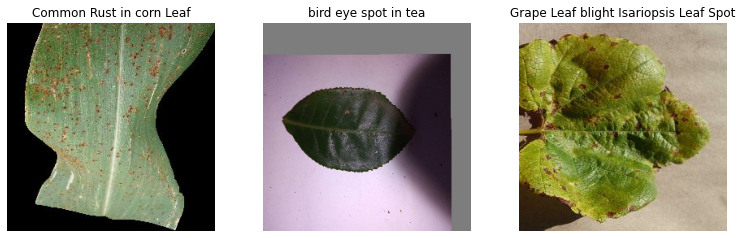

In [24]:
plt.figure(figsize=(13, 13))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(2):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        arr = labels[i].numpy()
        tuple = np.where(arr == 1)
        plt.title(class_names[tuple[0][0]])
        plt.axis("off")

## Modelo creado desde cero

In [52]:
inputs = keras.Input(shape=(size_x, size_y, 3)) 
x = layers.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(58, activation="softmax")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)

model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 128)       7385

## Entrenamiento y guardado de resultados del modelo uno

In [53]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="model1/best_version",
 save_best_only=True,
 monitor="val_loss")
]

In [54]:
model1.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [55]:
history = model1.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
145/145 [==============================] - 28s 185ms/step - loss: 4.0049 - accuracy: 0.1006 - val_loss: 2.7242 - val_accuracy: 0.2328
INFO:tensorflow:Assets written to: model1\best_version\assets
Epoch 2/30
145/145 [==============================] - 27s 184ms/step - loss: 2.4194 - accuracy: 0.3284 - val_loss: 1.9697 - val_accuracy: 0.4026
INFO:tensorflow:Assets written to: model1\best_version\assets
Epoch 3/30
145/145 [==============================] - 28s 185ms/step - loss: 1.6601 - accuracy: 0.5071 - val_loss: 1.7593 - val_accuracy: 0.4862
INFO:tensorflow:Assets written to: model1\best_version\assets
Epoch 4/30
145/145 [==============================] - 27s 182ms/step - loss: 1.1825 - accuracy: 0.6449 - val_loss: 1.6498 - val_accuracy: 0.5336
INFO:tensorflow:Assets written to: model1\best_version\assets
Epoch 5/30
145/145 [==============================] - 25s 168ms/step - loss: 0.8611 - accuracy: 0.7402 - val_loss: 1.4434 - val_accuracy: 0.6198
INFO:tensorflow:Assets writ

In [56]:
model1.save('model1/model')

INFO:tensorflow:Assets written to: model1/model\assets


In [57]:
np.save('model1/history.npy',history.history)

## Análisis de resultados

In [58]:
my_model0 = load_model('model0/model')
my_model1 = load_model('model1/model')

In [59]:
my_history0=np.load('model0/history.npy',allow_pickle='TRUE').item()
my_history1=np.load('model1/history.npy',allow_pickle='TRUE').item()

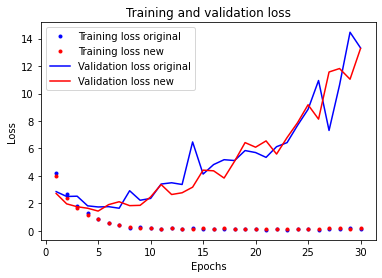

In [60]:
loss_0 = my_history0["loss"]
val_loss_0 = my_history0["val_loss"]
loss_1 = my_history1["loss"]
val_loss_1 = my_history1["val_loss"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, loss_0, "b.", label="Training loss original")
plt.plot(epochs, loss_1, "r.", label="Training loss new")
plt.plot(epochs, val_loss_0, "b", label="Validation loss original")
plt.plot(epochs, val_loss_1, "r", label="Validation loss new")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

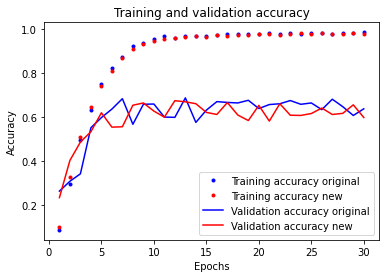

In [61]:
plt.clf()
acc_0 = my_history0["accuracy"]
val_acc_0 = my_history0["val_accuracy"]
acc_1 = my_history1["accuracy"]
val_acc_1 = my_history1["val_accuracy"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, acc_0, "b.", label="Training accuracy original")
plt.plot(epochs, acc_1, "r.", label="Training accuracy new")
plt.plot(epochs, val_acc_0, "b", label="Validation accuracy original")
plt.plot(epochs, val_acc_1, "r", label="Validation accuracy new")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [64]:
model = keras.models.load_model('model1/model')
results= model.evaluate(test_dataset)
results

19/19 [==============================] - 3s 75ms/step - loss: 13.5050 - accuracy: 0.5819


[13.505017280578613, 0.5818965435028076]

In [65]:
model = keras.models.load_model('model1/best_version')
results= model.evaluate(test_dataset)
results

19/19 [==============================] - 2s 75ms/step - loss: 1.4736 - accuracy: 0.5940


[1.4736422300338745, 0.5939655303955078]